In [11]:
import numpy as np
import os
import cv2
from os import walk
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

import warnings
warnings.filterwarnings('ignore')


def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def dice_loss(y_true, y_pred, smooth=1):
    
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    loss = 1 - dice
    return loss

# def dsc(y_true, y_pred):
#     smooth = 1.
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
#     return score

# def bce_dice_loss(y_true, y_pred):
#     loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
#     return loss
   

def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr  # 처음 5 에포크 동안은 학습률을 그대로 유지합니다.
    elif epoch >= 5 and len(dice_coefficients) > 0:
        # 5번째 에포크 이후에 Dice coefficient의 변화를 모니터링하고, 변화가 없다면 학습률을 0.1배로 줄입니다.
        last_dice_coefficient = dice_coefficients[-1]
        if all(coeff == last_dice_coefficient for coeff in dice_coefficients[-5:]):
            return lr * 0.1
        else:
            return lr
    else:
        return lr

# Load the dataset and preprocess the images and masks
data_path = "./test"
image_path = os.path.join(data_path, "images")
mask_path = os.path.join(data_path, "masks")

# Load the images and masks
images = []
masks = []
count = 0
for path, subdirs, files in os.walk(image_path):
    for name in files:
        imagepath = os.path.join(path, name)
        maskpath = imagepath.replace('images', 'masks').replace('tiff', 'png')

        print(imagepath + "  " + maskpath)
        # Load the image
        image = Image.open(imagepath)
        image = np.array(image)
        image = cv2.resize(image, (256, 256))

        # Load the mask
        mask = cv2.imread(maskpath, cv2.IMREAD_GRAYSCALE)

        # print(np.unique(mask)) # 0 76 149
        mask[mask != 0] = 1
        # mask[mask == 0] = 0
        # mask[mask == 76] = 1

        mask = cv2.resize(mask, (256, 256), interpolation=None)

        images.append(image)
        masks.append(mask)

# Convert the lists to numpy arrays
images = np.array(images)
masks = np.array(masks)
#masks = np.array(masks)

GT = np.zeros((masks.shape[0], masks.shape[1], masks.shape[2], 2))
for i in range(2):
    GT[:, :, :, i] = (masks == i)
print("%d images and %d masks detected" % (len(images), len(masks)))

# N = 5
# for i in range(N):
#     image = images[i]
#     GT0 = GT[i, :, :, 0]
#     GT1 = GT[i, :, :, 1]
# #     GT2 = GT[i, :, :, 2]
# #
#     plt.subplot(4, N, i + 1)
#     plt.imshow(image, cmap='gray')
# #
#     plt.subplot(4, N, N + i + 1)
#     plt.imshow(GT0, cmap='gray')
# #
#     plt.subplot(4, N, 2 * N + i + 1)
#     plt.imshow(GT1, cmap='gray')
#
#     plt.subplot(4, N, 3 * N + i + 1)
#     plt.imshow(GT2, cmap='gray')


# Normalize the images
images = images / 255.0

# Split the dataset into training and validation sets
x_train, x_val, y_train, y_val = traind_test_split(images, masks, test_size=0.2, random_state=42)

datagen =ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True
)
augmented_images =[]
augmented_masks = []
for image,mask in zip(x_train,y_train):
    image = np.expand_dims(image,axis=2)
    mask = np.expand_dims(mask,axis=2)
    
    seed = np.random.randint(1,10000)
    image_aug = datagen.random_transform(image,seed=seed)
    mask_aug = datagen.random_transform(mask,seed=seed)
    
    augmented_images.append(image_aug)
    augmented_masks.append(mask_aug)
agumented_images = np.array(augmented_images) 
agumented_masks = np.array(augmented_masks)

# x_train = np.concatenate([x_train,np.array(aug_images)])
# y_train = np.concatenate([y_train,np.array(aug_images)])


def unet(input_shape=(256, 256, 1)):
    inputs = Input(input_shape)

    # Contracting Path (Encoder)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottom
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Expansive Path (Decoder)
    up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)



    up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)
    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

model = unet()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0000001),
              loss=dice_loss,
              metrics=['accuracy', dice_coefficient])

lr_scheduler_callback = LearningRateScheduler(lr_scheduler)
# 모델 학습
dice_coefficients = []
for epoch in range(10):
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=1, batch_size=6, callbacks=[lr_scheduler_callback],verbose=1)
    dice_coefficient = history.history['dice_coefficient'][0]
    dice_coefficients.append(dice_coefficient)
    if epoch >= 5 and len(dice_coefficients) > 0:
        last_dice_coefficient = dice_coefficients[-1]
        if all(coeff == last_dice_coefficient for coeff in dice_coefficients[-5:]):
            K.set_value(model.optimizer.lr, model.optimizer.lr * 0.1)

# 모델 저장
model.save('brain_mri_v1.h5')

# 예측 수행
preds = model.predict(x_val)

./test/images/013LAADWI0005.tiff  ./test/masks/013LAADWI0005.png
./test/images/013LAAADC0013.tiff  ./test/masks/013LAAADC0013.png
./test/images/013LAADWI0016.tiff  ./test/masks/013LAADWI0016.png
./test/images/014CEADC0003.tiff  ./test/masks/014CEADC0003.png
./test/images/013LAAADC0010.tiff  ./test/masks/013LAAADC0010.png
./test/images/014SVOADC0005.tiff  ./test/masks/014SVOADC0005.png
./test/images/014LAAADC0016.tiff  ./test/masks/014LAAADC0016.png
./test/images/013CEADC0012.tiff  ./test/masks/013CEADC0012.png
./test/images/013SVOADC0010.tiff  ./test/masks/013SVOADC0010.png
./test/images/013SVOADC0002.tiff  ./test/masks/013SVOADC0002.png
./test/images/013CEADC0016.tiff  ./test/masks/013CEADC0016.png
./test/images/014CEADC0004.tiff  ./test/masks/014CEADC0004.png
./test/images/014CEADC0021.tiff  ./test/masks/014CEADC0021.png
./test/images/014SVODWI0021.tiff  ./test/masks/014SVODWI0021.png
./test/images/013CEDWI0021.tiff  ./test/masks/013CEDWI0021.png
./test/images/014LAAADC0013.tiff  ./t

./test/images/014LAADWI0021.tiff  ./test/masks/014LAADWI0021.png
./test/images/013SVOADC0017.tiff  ./test/masks/013SVOADC0017.png
./test/images/014SVODWI0005.tiff  ./test/masks/014SVODWI0005.png
./test/images/014SVOADC0006.tiff  ./test/masks/014SVOADC0006.png
./test/images/013SVOADC0016.tiff  ./test/masks/013SVOADC0016.png
./test/images/014SVODWI0015.tiff  ./test/masks/014SVODWI0015.png
./test/images/014LAAADC0024.tiff  ./test/masks/014LAAADC0024.png
./test/images/014LAADWI0015.tiff  ./test/masks/014LAADWI0015.png
./test/images/013SVOADC0015.tiff  ./test/masks/013SVOADC0015.png
./test/images/014CEDWI0020.tiff  ./test/masks/014CEDWI0020.png
./test/images/014CEDWI0022.tiff  ./test/masks/014CEDWI0022.png
./test/images/013SVODWI0014.tiff  ./test/masks/013SVODWI0014.png
./test/images/014LAADWI0008.tiff  ./test/masks/014LAADWI0008.png
./test/images/014SVOADC0011.tiff  ./test/masks/014SVOADC0011.png
./test/images/013CEADC0021.tiff  ./test/masks/013CEADC0021.png
./test/images/013CEADC0006.tiff

302 images and 302 masks detected
2/2 [==============================] - 9s 4s/step


2/2 [==============================] - 0s 156ms/step


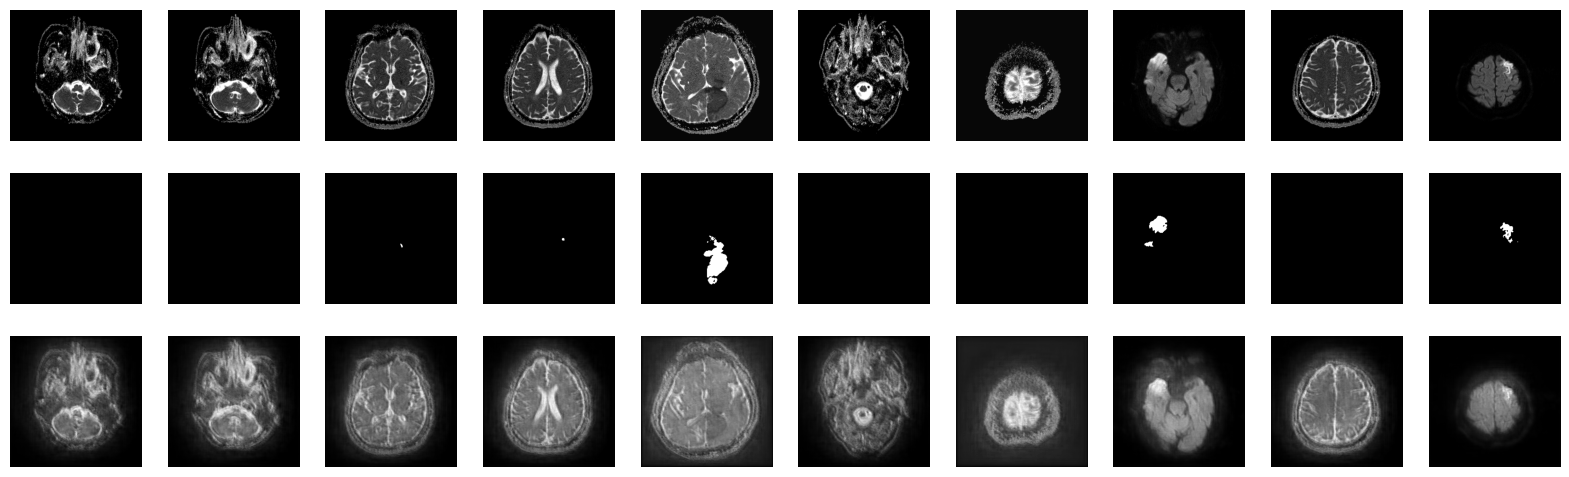

In [12]:
preds = model.predict(x_val)
fig, ax = plt.subplots(3,10,figsize=(20,6))
for i in range (10):
    
    ax[0,i].imshow(x_val[i],cmap=('gray'))
    ax[0,i].axis('off')
    ax[1,i].imshow(y_val[i],cmap=('gray'))
    ax[1,i].axis('off')
    ax[2,i].imshow(preds[i],cmap=('gray'))
    ax[2,i].axis('off')
plt.show()